In [12]:
import os

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

os.environ["KERAS_BACKEND"] = "torch"
import keras

In [13]:
keras.utils.set_random_seed(15151515)

In [14]:
df_train = pd.read_csv('data/tr80.csv')
df_test = pd.read_csv('data/tt20.csv')

In [15]:
df_train.describe()

,Unnamed: 0,ID,CLASS,B7_1,B7_2,B7_3,B7_4,B7_5,B7_6,B7_7,...,B4_3,B4_4,B4_5,B4_6,B4_7,B4_8,B4_9,B4_10,B4_11,B4_12
count,12140.000000,12140.000000,12140.000000,7363.000000,4313.000000,11898.000000,11906.000000,11907.000000,12109.000000,12134.000000,...,11898.000000,11906.000000,11907.000000,12109.000000,12134.000000,12130.000000,12137.000000,11813.000000,11445.000000,4055.000000
mean,6069.500000,7619.770181,8.340857,1608.827889,1720.006086,1510.175408,1845.876953,2613.479634,3405.248679,3432.516565,...,904.410846,943.534499,879.852440,866.655752,936.175972,947.397918,1005.228640,987.131508,920.339428,1087.467263
std,3504.660469,4445.453009,5.599224,1235.039249,1249.205711,776.402814,858.231710,1202.509465,1232.234781,1413.421517,...,519.929347,523.610878,556.097036,546.556647,636.263642,573.896767,534.294807,547.096558,681.492656,1299.846852
min,0.000000,2.000000,1.000000,1.000000,1.000000,13.000000,28.000000,88.000000,84.000000,99.000000,...,31.000000,79.000000,80.000000,111.000000,91.000000,55.000000,72.000000,1.000000,1.000000,1.000000
25%,3034.750000,3780.750000,3.000000,868.500000,1073.500000,949.125000,1200.000000,1648.500000,2603.000000,2421.000000,...,595.000000,636.000000,500.750000,529.000000,469.000000,554.125000,688.500000,659.000000,530.000000,406.500000
50%,6069.500000,7596.500000,7.000000,1327.000000,1469.000000,1424.500000,1774.000000,2536.500000,3433.000000,3260.000000,...,819.500000,837.250000,785.000000,746.000000,740.000000,856.000000,926.500000,896.000000,766.500000,717.000000
75%,9104.250000,11439.250000,11.000000,1936.500000,1965.500000,1956.000000,2388.750000,3444.000000,4235.000000,4483.000000,...,1079.375000,1116.000000,1094.000000,1054.000000,1258.000000,1216.000000,1209.000000,1188.000000,1111.000000,1237.000000
max,12139.000000,30219.000000,40.000000,13860.000000,11126.000000,6794.000000,9689.000000,7901.000000,7689.000000,11556.000000,...,7100.000000,9752.000000,6280.000000,9896.000000,6088.000000,6484.000000,6456.000000,15808.000000,10416.000000,11632.000000


In [16]:
bands = set()
dates = set()
for column in df_train.columns:
    if not column.startswith("B"):
        continue

    parts = column.split('_')
    if len(parts) != 2:
        continue

    if parts[0] not in bands:
        bands.add(parts[0])

    if parts[1] not in dates:
        dates.add(int(parts[1]))

bands = list(bands)
dates = list(dates)

bands.sort()
dates.sort()
dates = dates[3:-3]

drop_dates = [1, 2, 3, 10, 11, 12]

for date in drop_dates:
    for band in bands:
        df_train = df_train.drop(columns=[f"{band}_{date}"])
        df_test = df_test.drop(columns=[f"{band}_{date}"])

df_train = df_train.dropna()
df_test = df_test.dropna()

for band in bands:
    for date in dates:
        df_train[f"{band}_{date}"] = df_train[f"{band}_{date}"].fillna(20000) / 10000
        df_test[f"{band}_{date}"] = df_test[f"{band}_{date}"].fillna(20000) / 10000

df_train = df_train[df_train.groupby("CLASS")["CLASS"].transform('count').ge(20)]
df_test = df_test[df_test.groupby("CLASS")["CLASS"].transform('count').ge(20)]

In [17]:
df_train.shape

(11557, 76)

In [18]:
print(f"Bands count: {len(bands)}")
print(bands)

print(f"Dates count: {len(dates)}")
print(dates)

Bands count: 12
['B1', 'B11', 'B12', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B8A', 'B9']
Dates count: 6
[4, 5, 6, 7, 8, 9]


In [19]:
train_classes = df_train["CLASS"].unique()
train_classes.sort()

train_classes_part1 = train_classes[:10]

print("Initial classes")
print(len(train_classes_part1))
print(train_classes_part1)

print("Final classes")
print(len(train_classes))
print(train_classes)

Initial classes
10
[ 1  2  3  4  5  6  7  8 10 11]
Final classes
21
[ 1  2  3  4  5  6  7  8 10 11 12 13 14 15 16 17 18 19 21 26 34]


In [20]:
mapper = [None]*41
for i in range(len(train_classes)):
    mapper[train_classes[i]] = i

In [23]:
def pd_2_mts_XY(df, train_classes):
    X = np.empty((df.shape[0], len(dates), len(bands)))
    Y = np.zeros((df.shape[0], len(train_classes)))

    counter = 0
    for _, row in df.iterrows():
        if row["CLASS"] not in train_classes:
            continue

        for date_i in range(len(dates)):
            for band_i in range(len(bands)):
                X[counter, date_i, band_i] = row[f"{bands[band_i]}_{dates[date_i]}"]
        
        Y[counter, mapper[int(row["CLASS"])]] = 1
        counter += 1

    return X[:counter], Y[:counter]


In [24]:
train_X, train_Y = pd_2_mts_XY(df_train, train_classes_part1)

test_X, test_Y = pd_2_mts_XY(df_test, train_classes_part1)

In [25]:
train_X.shape

(8935, 6, 12)

In [26]:
model = keras.Sequential(
    [
        keras.layers.Input(shape=(len(dates), len(bands))),
        keras.layers.Dropout(0.2),
        keras.layers.GRU(64, return_sequences=True),
        keras.layers.GRU(32),
        keras.layers.Dense(len(train_classes_part1), activation="softmax")
    ]
)

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dropout (Dropout)               │ (None, 6, 12)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru (GRU)                       │ (None, 6, 64)          │        14,976 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_1 (GRU)                     │ (None, 32)             │         9,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 10)             │           330 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,714 (96.54 KB)

 Trainable params: 24,714 (96.54 KB)

 Non-trainable params: 0 (0.00 B)

In [27]:
model.compile(
    optimizer="adam",
    loss="categorical_crossentropy",
    metrics=["categorical_accuracy", "f1_score", "precision", "recall"],
)

In [28]:
history = model.fit(
    train_X,
    train_Y,
    batch_size=128,
    epochs=50,
    verbose=1,
    validation_data=(test_X, test_Y)
)

Epoch 1/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 3s 40ms/step - categorical_accuracy: 0.2021 - f1_score: 0.0595 - loss: 2.1275 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_categorical_accuracy: 0.2615 - val_f1_score: 0.0485 - val_loss: 1.8357 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 3s 39ms/step - categorical_accuracy: 0.3687 - f1_score: 0.1467 - loss: 1.7098 - precision: 0.4713 - recall: 0.0546 - val_categorical_accuracy: 0.6384 - val_f1_score: 0.3643 - val_loss: 1.0157 - val_precision: 0.7826 - val_recall: 0.2947
Epoch 3/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 3s 37ms/step - categorical_accuracy: 0.5452 - f1_score: 0.3230 - loss: 1.1770 - precision: 0.6987 - recall: 0.3105 - val_categorical_accuracy: 0.6983 - val_f1_score: 0.4427 - val_loss: 0.8548 - val_precision: 0.7998 - val_recall: 0.4804
Epoch 4/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 3s 39ms/step - categorical_accuracy: 0.5984 - f1_score: 0.3835 - loss: 1.0470 - precision: 0.6940 - recall: 0.4186 - val_

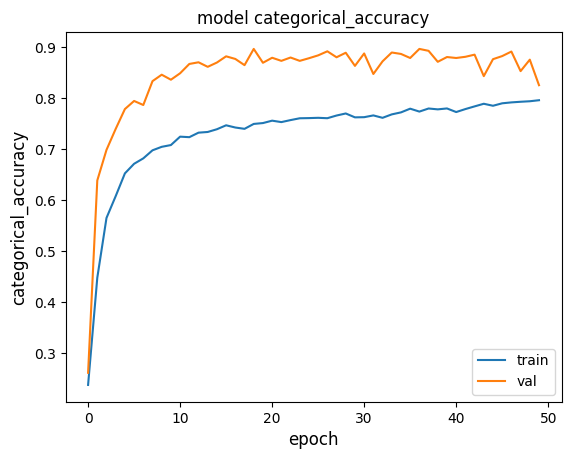

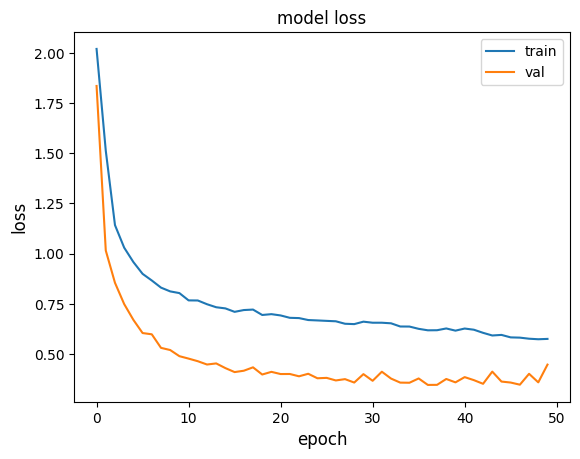

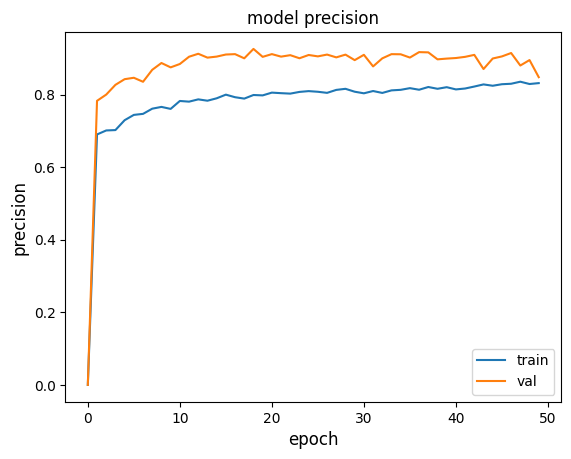

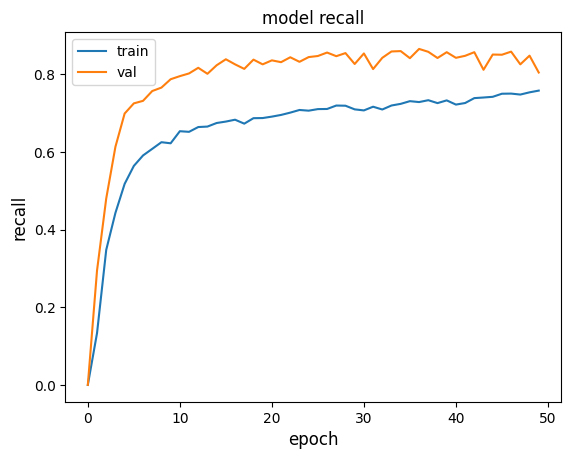

In [29]:
metrics = ["categorical_accuracy", "loss", "precision", "recall"]

for metric in metrics:
    plt.figure()
    plt.plot(history.history[metric])
    plt.plot(history.history["val_" + metric])
    plt.title("model " + metric)
    plt.ylabel(metric, fontsize="large")
    plt.xlabel("epoch", fontsize="large")
    plt.legend(["train", "val"], loc="best")
    plt.show()
    plt.close()

In [30]:
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay

In [31]:
pred_train = np.argmax(model.predict(train_X), axis=1)
pred_test = np.argmax(model.predict(test_X), axis=1)

280/280 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step


In [32]:
print(classification_report(np.argmax(train_Y, axis=1), pred_train))

              precision    recall  f1-score   support

           0       0.98      0.96      0.97       415
           1       0.85      0.93      0.89      2194
           2       1.00      0.23      0.37       382
           3       0.00      0.00      0.00        63
           4       0.58      0.98      0.73      1388
           5       1.00      0.03      0.06        62
           6       0.93      0.70      0.80      1544
           7       0.81      0.11      0.20       631
           8       0.95      0.97      0.96       632
           9       0.85      0.93      0.89      1624

    accuracy                           0.80      8935
   macro avg       0.80      0.59      0.59      8935
weighted avg       0.83      0.80      0.77      8935



e:\STUDY\deep-learning-2024\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
e:\STUDY\deep-learning-2024\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
e:\STUDY\deep-learning-2024\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [33]:
print(classification_report(np.argmax(test_Y, axis=1), pred_test))

              precision    recall  f1-score   support

           0       1.00      0.97      0.98        96
           1       0.88      0.93      0.90       544
           2       1.00      0.20      0.34        88
           4       0.60      0.99      0.75       340
           6       0.95      0.69      0.80       380
           7       0.96      0.17      0.28       150
           8       0.97      0.99      0.98       146
           9       0.85      0.96      0.90       394

    accuracy                           0.83      2138
   macro avg       0.90      0.74      0.74      2138
weighted avg       0.87      0.83      0.80      2138



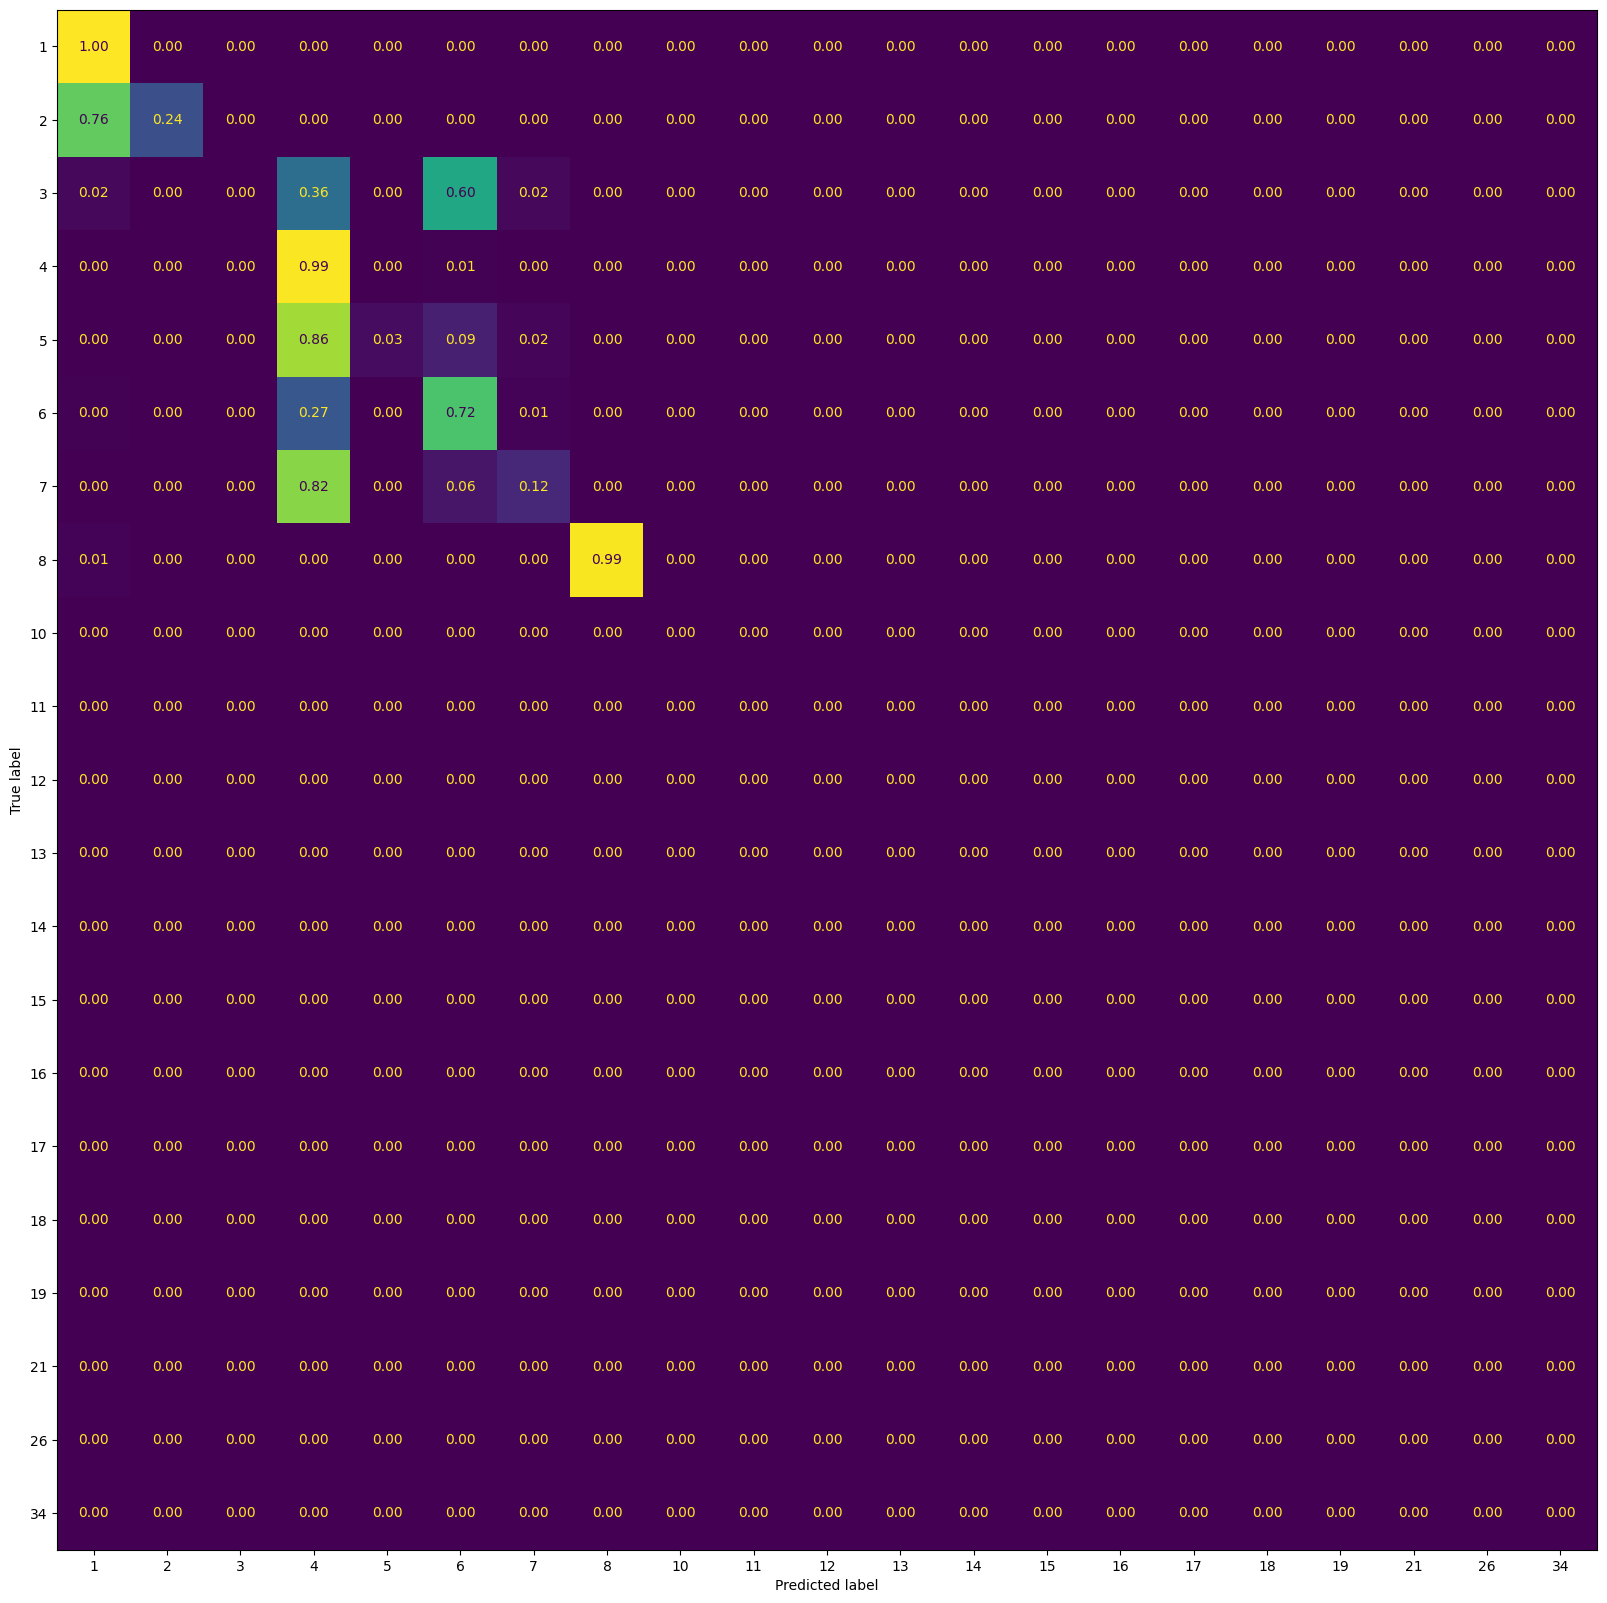

In [34]:
fig, ax = plt.subplots(figsize=(20,20))
ConfusionMatrixDisplay.from_predictions(np.argmax(train_Y, axis=1), pred_train, normalize='true', labels=train_classes, display_labels=train_classes, values_format=".2f", ax=ax, colorbar=False)

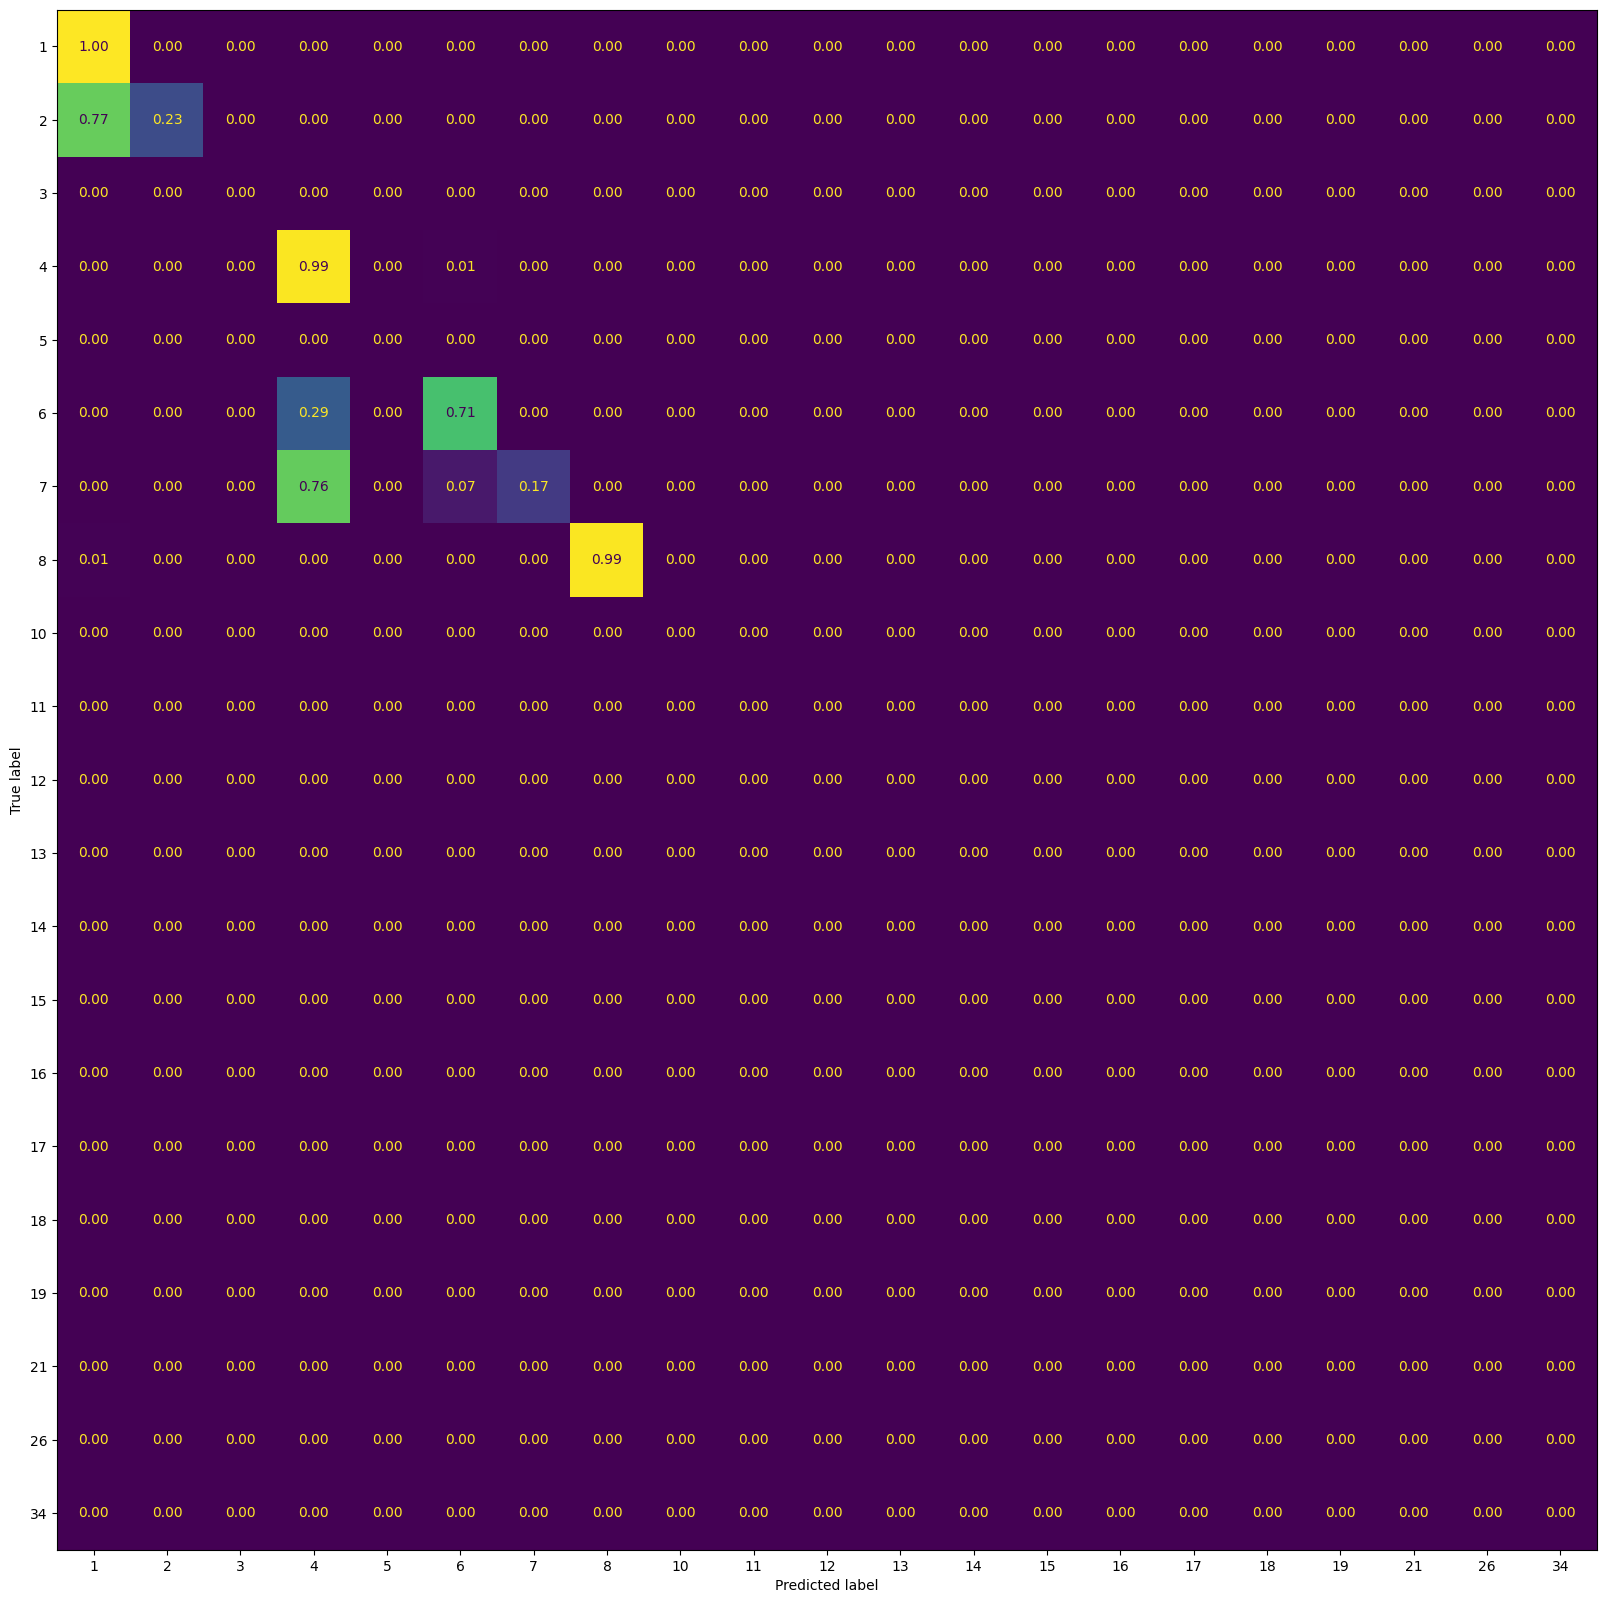

In [35]:
fig, ax = plt.subplots(figsize=(20,20))
ConfusionMatrixDisplay.from_predictions(np.argmax(test_Y, axis=1), pred_test, normalize='true', labels=train_classes, display_labels=train_classes, values_format=".2f", ax=ax, colorbar=False)